# Analysis of Individual Judgments and Reward Model Scores

## Preparations

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, zscore
import numpy as np

## Load Data

In [2]:
# read dataframes wiht reward model scores and our annotations
summaries_reward_model = pd.read_csv("baumholzEtAl_text_summaries_4_5.csv")
summaries_annotated = pd.read_excel("text_summaries_with_linesmeikesmarcs_annotations.xlsx")

In [3]:
summaries_annotated

,Unnamed: 0.1,Unnamed: 0,prompt_id,text,Outputs,summaryOnly,independence,context,accuracy,completeness,grammar,readability,brevity,final_score
0,0,0,415,SUBREDDIT: r/relationship_advice\nTITLE: My [M...,SUBREDDIT: r/relationship_advice\nTITLE: My [M...,I feel as though my girlfriend and I need to...,1.0,2.0,1.0,1.0,1.0,2.0,1.0,9.0
1,1,1,440,"SUBREDDIT: r/AskReddit\nTITLE: Reddit, how do ...","SUBREDDIT: r/AskReddit\nTITLE: Reddit, how do ...","Teenagers wreck flowers, pour salt on cars, ...",1.0,1.0,2.0,1.0,1.0,2.0,1.0,9.0
2,2,2,466,SUBREDDIT: r/relationships\nTITLE: My siblings...,SUBREDDIT: r/relationships\nTITLE: My siblings...,I feel uncomfortable paying my siblings back...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0
3,3,3,571,SUBREDDIT: r/dogs\nTITLE: [Help] Older dog has...,SUBREDDIT: r/dogs\nTITLE: [Help] Older dog has...,Older dog has peripheral vestibular disease....,1.0,1.0,2.0,1.0,1.0,2.0,1.0,9.0
4,4,4,627,SUBREDDIT: r/relationship_advice\nTITLE: I [20...,SUBREDDIT: r/relationship_advice\nTITLE: I [20...,Girlfriend has been working all day and has ...,1.0,1.0,1.0,1.0,1.0,2.0,1.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,99,6054,SUBREDDIT: r/tifu\nTITLE: TIFU by attempting t...,SUBREDDIT: r/tifu\nTITLE: TIFU by attempting t...,I tried to make a toaster oven out of my hou...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0
100,100,100,6310,SUBREDDIT: r/relationships\nTITLE: Me(21f) and...,SUBREDDIT: r/relationships\nTITLE: Me(21f) and...,ex is buying condoms with me and getting mad...,0.0,1.0,0.0,0.0,0.0,0.5,0.0,1.5
101,101,101,6367,SUBREDDIT: r/offmychest\nTITLE: someone stole ...,SUBREDDIT: r/offmychest\nTITLE: someone stole ...,I was robbed and my car was wrecked while I ...,1.0,0.5,0.5,0.0,1.0,0.0,0.0,3.0
102,102,102,6371,SUBREDDIT: r/self\nTITLE: i don't give a rat's...,SUBREDDIT: r/self\nTITLE: i don't give a rat's...,"I don't give a rat's ass about your ""rage"" l...",1.0,1.0,1.0,0.5,0.5,1.0,1.0,6.0


In [30]:
# combine the two dataframes
summaries = summaries_annotated
summaries['predicted_reward'] = summaries_reward_model['predicted_reward']

# clean and rename columns
summaries = summaries.drop(columns=['Unnamed: 0.1'])
summaries = summaries.rename(columns={'Unnamed: 0': 'id'})

# columns with tags for the (mis)matches and linguistic criteria
match_tags = ['match']*52 + ['mismatch']*52
ling_crit = (['sent_len']*13 + ['sentim']*13 + ['lem']*13 + ['pos']*13) * 2

# add columns
summaries['match_mismatch'] = match_tags
summaries['ling_criteria'] = ling_crit

summaries.head()

,id,prompt_id,text,Outputs,summaryOnly,independence,context,accuracy,completeness,grammar,readability,brevity,final_score,predicted_reward,match_mismatch,ling_criteria
0,0,415,SUBREDDIT: r/relationship_advice\nTITLE: My [M...,SUBREDDIT: r/relationship_advice\nTITLE: My [M...,I feel as though my girlfriend and I need to...,1.0,2.0,1.0,1.0,1.0,2.0,1.0,9.0,3.135,match,sent_len
1,1,440,"SUBREDDIT: r/AskReddit\nTITLE: Reddit, how do ...","SUBREDDIT: r/AskReddit\nTITLE: Reddit, how do ...","Teenagers wreck flowers, pour salt on cars, ...",1.0,1.0,2.0,1.0,1.0,2.0,1.0,9.0,3.768,match,sent_len
2,2,466,SUBREDDIT: r/relationships\nTITLE: My siblings...,SUBREDDIT: r/relationships\nTITLE: My siblings...,I feel uncomfortable paying my siblings back...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0,2.398,match,sent_len
3,3,571,SUBREDDIT: r/dogs\nTITLE: [Help] Older dog has...,SUBREDDIT: r/dogs\nTITLE: [Help] Older dog has...,Older dog has peripheral vestibular disease....,1.0,1.0,2.0,1.0,1.0,2.0,1.0,9.0,4.273,match,sent_len
4,4,627,SUBREDDIT: r/relationship_advice\nTITLE: I [20...,SUBREDDIT: r/relationship_advice\nTITLE: I [20...,Girlfriend has been working all day and has ...,1.0,1.0,1.0,1.0,1.0,2.0,1.0,8.0,3.953,match,sent_len


## Normalize our Individual Scores

In [52]:
annotations_line = summaries[0:36]
annotations_marc = summaries[36:72]
annotations_meike = summaries[72:104]

In [111]:
def normalize_z_score(sample, desired_mean, desired_std):
    mean = np.mean(sample)
    std = np.std(sample)
    z_score = (sample - mean) / std
    normalized_sample = desired_mean + z_score * desired_std
    return normalized_sample

In [112]:
# normalize our indiv judgments
norm_line = normalize_z_score(annotations_line['final_score'].values, 5, 2)
norm_marc = normalize_z_score(annotations_marc['final_score'].values, 5, 2)
norm_meike = normalize_z_score(annotations_meike['final_score'].values, 5, 2)

In [113]:
# append normed scores in 1 list
normed_score = []
for x in norm_line:
    normed_score.append(x)
for x in norm_marc:
    normed_score.append(x)
for x in norm_meike:
    normed_score.append(x)

# add column with normed scores into summary-df
summaries['normed_score'] = normed_score
summaries

,id,prompt_id,text,Outputs,summaryOnly,independence,context,accuracy,completeness,grammar,readability,brevity,final_score,predicted_reward,match_mismatch,ling_criteria,normed_score
0,0,415,SUBREDDIT: r/relationship_advice\nTITLE: My [M...,SUBREDDIT: r/relationship_advice\nTITLE: My [M...,I feel as though my girlfriend and I need to...,1.0,2.0,1.0,1.0,1.0,2.0,1.0,9.0,3.135,match,sent_len,7.298097
1,1,440,"SUBREDDIT: r/AskReddit\nTITLE: Reddit, how do ...","SUBREDDIT: r/AskReddit\nTITLE: Reddit, how do ...","Teenagers wreck flowers, pour salt on cars, ...",1.0,1.0,2.0,1.0,1.0,2.0,1.0,9.0,3.768,match,sent_len,7.298097
2,2,466,SUBREDDIT: r/relationships\nTITLE: My siblings...,SUBREDDIT: r/relationships\nTITLE: My siblings...,I feel uncomfortable paying my siblings back...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0,2.398,match,sent_len,4.116117
3,3,571,SUBREDDIT: r/dogs\nTITLE: [Help] Older dog has...,SUBREDDIT: r/dogs\nTITLE: [Help] Older dog has...,Older dog has peripheral vestibular disease....,1.0,1.0,2.0,1.0,1.0,2.0,1.0,9.0,4.273,match,sent_len,7.298097
4,4,627,SUBREDDIT: r/relationship_advice\nTITLE: I [20...,SUBREDDIT: r/relationship_advice\nTITLE: I [20...,Girlfriend has been working all day and has ...,1.0,1.0,1.0,1.0,1.0,2.0,1.0,8.0,3.953,match,sent_len,5.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,6054,SUBREDDIT: r/tifu\nTITLE: TIFU by attempting t...,SUBREDDIT: r/tifu\nTITLE: TIFU by attempting t...,I tried to make a toaster oven out of my hou...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.502,mismatch,pos,3.300691
100,100,6310,SUBREDDIT: r/relationships\nTITLE: Me(21f) and...,SUBREDDIT: r/relationships\nTITLE: Me(21f) and...,ex is buying condoms with me and getting mad...,0.0,1.0,0.0,0.0,0.0,0.5,0.0,1.5,1.526,mismatch,pos,2.109935
101,101,6367,SUBREDDIT: r/offmychest\nTITLE: someone stole ...,SUBREDDIT: r/offmychest\nTITLE: someone stole ...,I was robbed and my car was wrecked while I ...,1.0,0.5,0.5,0.0,1.0,0.0,0.0,3.0,1.565,mismatch,pos,3.300691
102,102,6371,SUBREDDIT: r/self\nTITLE: i don't give a rat's...,SUBREDDIT: r/self\nTITLE: i don't give a rat's...,"I don't give a rat's ass about your ""rage"" l...",1.0,1.0,1.0,0.5,0.5,1.0,1.0,6.0,0.891,mismatch,pos,5.682204


In [132]:
# normalize scores again by substracting mean
pred_rew_normed = summaries['predicted_reward'].values - summaries['predicted_reward'].mean()
summaries['pred_rew_normed'] = pred_rew_normed
indiv_normed = summaries['normed_score'].values - summaries['normed_score'].mean()
summaries['indiv_normed'] = indiv_normed



Ttest_1sampResult(statistic=-6.091276839885713e-15, pvalue=0.9999999999999951)

In [ ]:
d = pred_rew_normed - indiv_normed
ttest_1samp(d, popmean=0)
# -> no sign difference between the two scoring methods -> now dive into further analysis

In [ ]:
# save it in csv
summaries.to_csv('prompts_summaries_ourscores_rewardscore.csv')

## Comparison Mismatch & Match in Our Annotations

In [135]:
# split into match and mismatch
matches = summaries.loc[summaries.match_mismatch == 'match']
mismatches = summaries.loc[summaries.match_mismatch == 'mismatch']

In [136]:
# split into criteria
matches_sentlen = summaries.loc[(summaries.match_mismatch == 'match') & (summaries.ling_criteria == 'sent_len')]
matches_sentim = summaries.loc[(summaries.match_mismatch == 'match') & (summaries.ling_criteria == 'sentim')]
matches_lem = summaries.loc[(summaries.match_mismatch == 'match') & (summaries.ling_criteria == 'lem')]
matches_pos = summaries.loc[(summaries.match_mismatch == 'match') & (summaries.ling_criteria == 'pos')]

mismatches_sentlen = summaries.loc[(summaries.match_mismatch == 'mismatch') & (summaries.ling_criteria == 'sent_len')]
mismatches_sentim = summaries.loc[(summaries.match_mismatch == 'mismatch') & (summaries.ling_criteria == 'sentim')]
mismatches_lem = summaries.loc[(summaries.match_mismatch == 'mismatch') & (summaries.ling_criteria == 'lem')]
mismatches_pos = summaries.loc[(summaries.match_mismatch == 'mismatch') & (summaries.ling_criteria == 'pos')]

In [137]:
# two sample ttest: is there significant diff between the annotated scores for matching and mismatching summaries? H0: there is no diff, H1: there is diff

d = matches['indiv_normed'].values - mismatches['indiv_normed'].values
ttest_1samp(d, popmean = 0)

Ttest_1sampResult(statistic=0.8707442642229599, pvalue=0.3879741193468982)

In [138]:
# two sample ttest: is there significant diff between the annotated scores for matching and mismatching summaries? H0: there is no diff, H1: there is diff

d = matches['normed_score'].values - mismatches['normed_score'].values
ttest_1samp(d, popmean = 0)

Ttest_1sampResult(statistic=0.8707442642229599, pvalue=0.3879741193468982)

(0.0, 10.0)

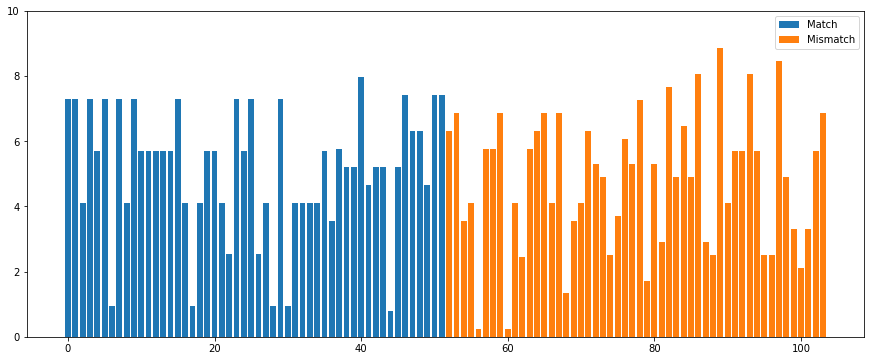

In [139]:
# TODO: aussagekräftigeren plot !!!

plt.figure(figsize = (15, 6))
plt.bar(matches['id'], matches['normed_score'])
plt.bar(mismatches['id'], mismatches['normed_score'])
plt.legend(['Match', 'Mismatch'])
plt.ylim(0,10)

<BarContainer object of 2 artists>

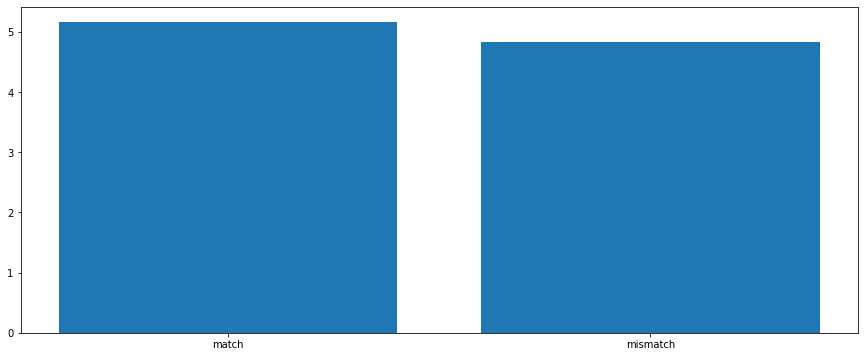

In [140]:
# TODO: add std !!! -> meikes code

plt.figure(figsize = (15, 6))
plt.bar(['match', 'mismatch'], [matches['normed_score'].mean(), mismatches['normed_score'].mean()])

## Comparison Mismatch & Match in Reward Model Scores

In [141]:
# two sample ttest: is there significant diff between the annotated scores for matching and mismatching summaries? H0: there is no diff, H1: there is diff

d = matches['predicted_reward'].values - mismatches['predicted_reward'].values
ttest_1samp(d, popmean = 0)

Ttest_1sampResult(statistic=0.6962163959652462, pvalue=0.4894542593971918)

In [142]:
d = matches['pred_rew_normed'].values - mismatches['pred_rew_normed'].values
ttest_1samp(d, popmean = 0)

Ttest_1sampResult(statistic=0.6962163959652462, pvalue=0.4894542593971918)

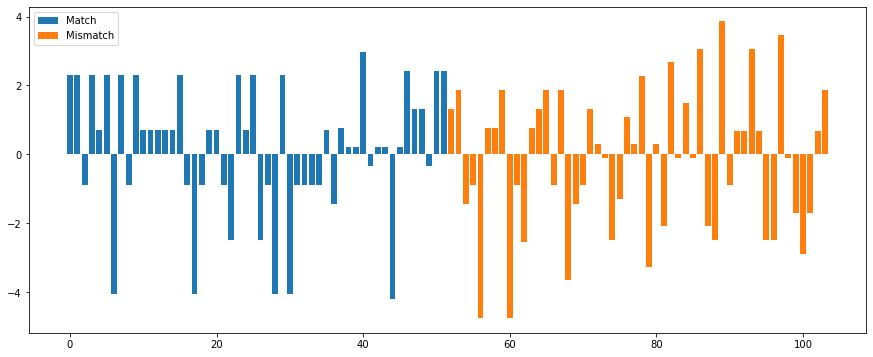

In [145]:
# TODO: add std !!! -> meikes code

plt.figure(figsize = (15, 6))
plt.bar(matches['id'], matches['indiv_normed'])
plt.bar(mismatches['id'], mismatches['indiv_normed'])
plt.legend(['Match', 'Mismatch'])

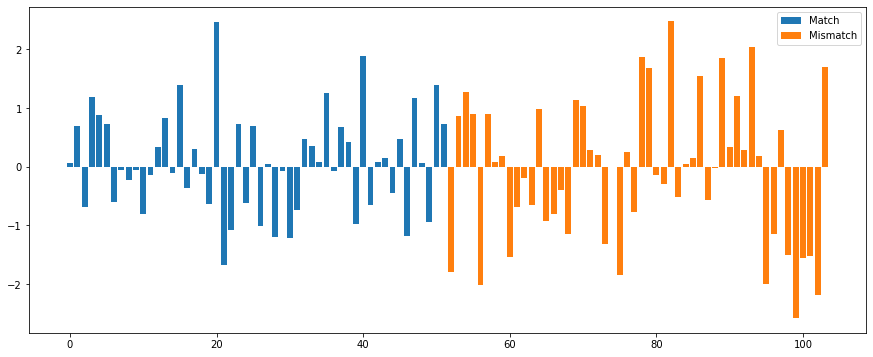

In [144]:
# TODO: add std !!! -> meikes code

plt.figure(figsize = (15, 6))
plt.bar(matches['id'], matches['pred_rew_normed'])
plt.bar(mismatches['id'], mismatches['pred_rew_normed'])
plt.legend(['Match', 'Mismatch'])

(0.0, 10.0)

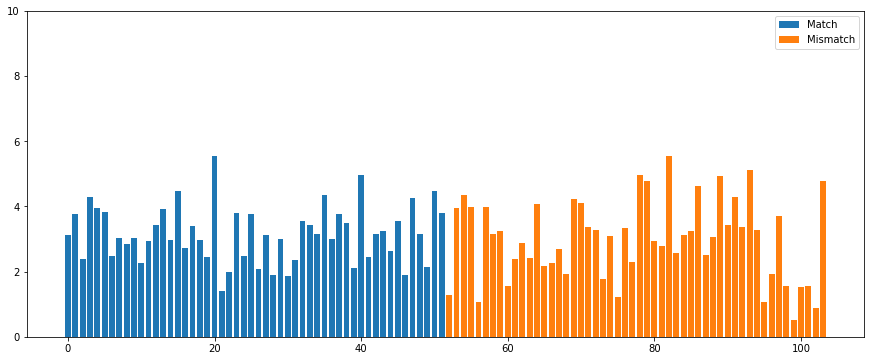

In [25]:
# TODO: add std !!! -> meikes code

plt.figure(figsize = (15, 6))
plt.bar(matches['id'], matches['predicted_reward'])
plt.bar(mismatches['id'], mismatches['predicted_reward'])
plt.legend(['Match', 'Mismatch'])
plt.ylim(0,10)

<BarContainer object of 2 artists>

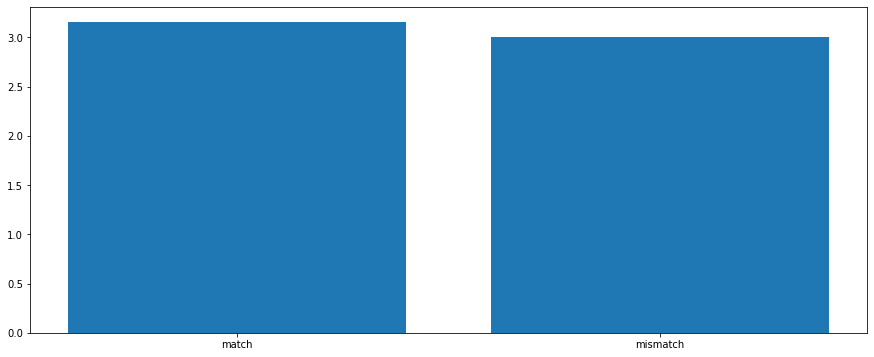

In [26]:
# # add std

plt.figure(figsize = (15, 6))
plt.bar(['match', 'mismatch'], [matches['predicted_reward'].mean(), mismatches['predicted_reward'].mean()])

## Comparison of (Mis)Matching Criteria in Our Annotations

C:\Users\line\AppData\Local\Temp\ipykernel_1140\681452393.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.bar(x-0.3, matches_sentlen.mean()[2:10], width = 0.20)
C:\Users\line\AppData\Local\Temp\ipykernel_1140\681452393.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.bar(x-0.1, matches_sentim.mean()[2:10], width = 0.20)
C:\Users\line\AppData\Local\Temp\ipykernel_1140\681452393.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.bar(x+0.1, matches_lem.mean()[2:10], wi

Text(0.5, 1.0, 'Matching')

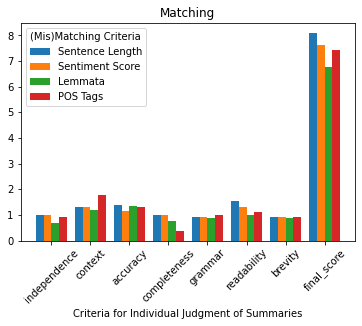

In [27]:
x = np.arange(8) 
plt.bar(x-0.3, matches_sentlen.mean()[2:10], width = 0.20)
plt.bar(x-0.1, matches_sentim.mean()[2:10], width = 0.20)
plt.bar(x+0.1, matches_lem.mean()[2:10], width = 0.20)
plt.bar(x+0.3, matches_pos.mean()[2:10], width = 0.20)
plt.xticks(x, ['independence', 'context', 'accuracy', 'completeness', 'grammar', 'readability', 'brevity', 'final_score'], rotation=45)
plt.xlabel('Criteria for Individual Judgment of Summaries')
plt.legend(["Sentence Length", "Sentiment Score", "Lemmata", "POS Tags"], title = '(Mis)Matching Criteria') 
plt.title('Matching')

C:\Users\line\AppData\Local\Temp\ipykernel_1140\4268661100.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.bar(x-0.3, mismatches_sentlen.mean()[2:10], width = 0.20)
C:\Users\line\AppData\Local\Temp\ipykernel_1140\4268661100.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.bar(x-0.1, mismatches_sentim.mean()[2:10], width = 0.20)
C:\Users\line\AppData\Local\Temp\ipykernel_1140\4268661100.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.bar(x+0.1, mismatches_lem.mean

Text(0.5, 1.0, 'Mismatching')

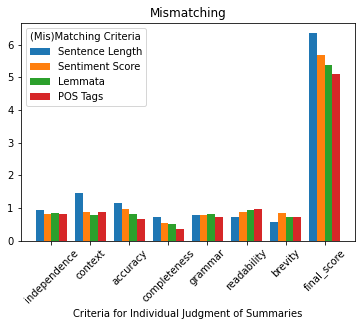

In [28]:
x = np.arange(8) 
plt.bar(x-0.3, mismatches_sentlen.mean()[2:10], width = 0.20)
plt.bar(x-0.1, mismatches_sentim.mean()[2:10], width = 0.20)
plt.bar(x+0.1, mismatches_lem.mean()[2:10], width = 0.20)
plt.bar(x+0.3, mismatches_pos.mean()[2:10], width = 0.20)
plt.xticks(x, ['independence', 'context', 'accuracy', 'completeness', 'grammar', 'readability', 'brevity', 'final_score'], rotation=45)
plt.xlabel('Criteria for Individual Judgment of Summaries')
plt.legend(["Sentence Length", "Sentiment Score", "Lemmata", "POS Tags"], title = '(Mis)Matching Criteria') 
plt.title('Mismatching')

## Comparison of (Mis)Matching Criteria in Reward Model Scores

C:\Users\line\AppData\Local\Temp\ipykernel_1140\2932192015.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.bar(x-0.4, matches_sentlen.mean()['predicted_reward'], width = 0.20)
C:\Users\line\AppData\Local\Temp\ipykernel_1140\2932192015.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.bar(x-0.2, matches_sentim.mean()['predicted_reward'], width = 0.20)
C:\Users\line\AppData\Local\Temp\ipykernel_1140\2932192015.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.bar(x+0.

Text(0.5, 1.0, 'Mismatching')

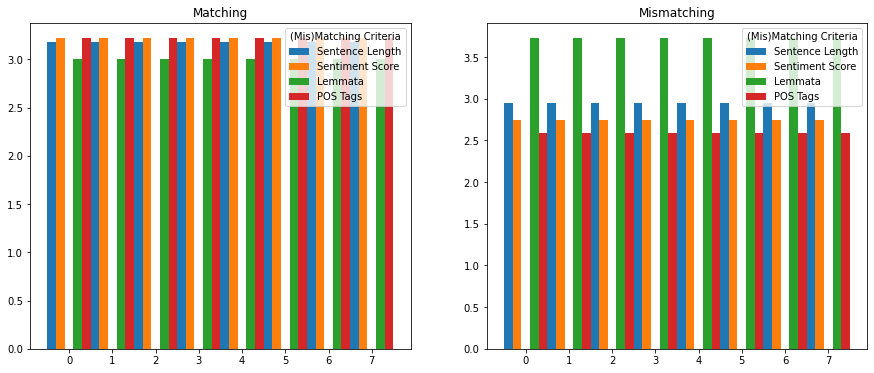

In [29]:
x = np.arange(8) 

plt.figure(figsize = (15, 6))

plt.subplot(121)
plt.bar(x-0.4, matches_sentlen.mean()['predicted_reward'], width = 0.20)
plt.bar(x-0.2, matches_sentim.mean()['predicted_reward'], width = 0.20)
plt.bar(x+0.2, matches_lem.mean()['predicted_reward'], width = 0.20)
plt.bar(x+0.4, matches_pos.mean()['predicted_reward'], width = 0.20)
plt.legend(["Sentence Length", "Sentiment Score", "Lemmata", "POS Tags"], title = '(Mis)Matching Criteria') 
plt.title('Matching')

plt.subplot(122)
plt.bar(x-0.4, mismatches_sentlen.mean()['predicted_reward'], width = 0.20)
plt.bar(x-0.2, mismatches_sentim.mean()['predicted_reward'], width = 0.20)
plt.bar(x+0.2, mismatches_lem.mean()['predicted_reward'], width = 0.20)
plt.bar(x+0.4, mismatches_pos.mean()['predicted_reward'], width = 0.20)
plt.legend(["Sentence Length", "Sentiment Score", "Lemmata", "POS Tags"], title = '(Mis)Matching Criteria') 
plt.title('Mismatching')